In [1]:
import numpy as np
import torch
import os
import pandas as pd
import itertools as it
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler



from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp /content/drive/MyDrive/Models/utils_arm.py .
from utils_arm import *

# !pip install optuna
# import optuna

In [3]:
!pip install positional-encodings[pytorch]
from positional_encodings.torch_encodings import PositionalEncoding1D, Summer

In [4]:
def read_range(f_path, segment_index, device):
  sub_dif = pd.read_csv(f_path, header=None).iloc[:, segment_index]
  sub_dif = sub_dif.reset_index(inplace=False, drop=True)
  sub_dif = sub_dif.to_numpy().reshape(-1, len(segment_index)*3)
  sub_dif = torch.from_numpy(sub_dif).to(device)
  return sub_dif

def nRMSE_compute(my_L_tar, my_L_pred):
    tot_loss = torch.sum(torch.sum(((my_L_tar.to(device) - my_L_pred.to(device))/my_range)** 2))
    tot_loss = torch.sqrt(tot_loss / (len(Test_List)*(101-input_frames)*segment_len))
    return tot_loss

def RMSE_compute(my_L_tar, my_L_pred):
    tot_loss = torch.sum(torch.sum(((my_L_tar.to(device) - my_L_pred.to(device)))** 2))
    tot_loss = torch.sqrt(tot_loss / (len(Test_List)*(101-input_frames)*segment_len))
    return tot_loss


def r2_compute(my_L_tar, my_L_pred):
    scaler = StandardScaler()
    scaled_y_true = scaler.fit_transform(my_L_tar.reshape(-1, 1))
    scaled_y_pred = scaler.transform(my_L_pred.reshape(-1, 1))

    r2 = r2_score(scaled_y_true, scaled_y_pred)
    return r2

In [5]:
input_frames, predicted_frames, my_stride = 25, 1, 1
num_of_sub = 20
val_sub = [2, 8, 9, 14]
test_sub = [13, 15]
segment_inds = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
body_segment_name = 'Arm'

In [6]:
# path to proceesed folder
proceesed_path = '/content/drive/MyDrive/DATA/Normalized'
val_pathes = []
for i in val_sub:
  val_pathes.append(os.path.join(proceesed_path, f's{i}_fn'))

test_pathes = []
for i in test_sub:
  test_pathes.append(os.path.join(proceesed_path, f's{i}_fn'))

path_to_subject_mean = os.path.join('/content/drive/MyDrive/data normalization/mean-std', 'mean.csv')
path_to_subject_std = os.path.join('/content/drive/MyDrive/data normalization/mean-std', 'std.csv')
path_to_subject_range = os.path.join('/content/drive/MyDrive/data normalization/mean-std', 'dif.csv')

path_to_folder = '/content/drive/MyDrive/Models/Transformer_Arm'

In [7]:
val_pathes, test_pathes

(['/content/drive/MyDrive/DATA/Normalized/s2_fn',
  '/content/drive/MyDrive/DATA/Normalized/s8_fn',
  '/content/drive/MyDrive/DATA/Normalized/s9_fn',
  '/content/drive/MyDrive/DATA/Normalized/s14_fn'],
 ['/content/drive/MyDrive/DATA/Normalized/s13_fn',
  '/content/drive/MyDrive/DATA/Normalized/s15_fn'])

In [8]:
Val_List = []
Test_List = []
my_path_list = []

for val_path in val_pathes:
  test_ls, segment_len, _ = read_test(val_path, body_segment_name)
  Val_List.extend(test_ls)

print(len(test_ls), test_ls[0].shape)

for test_path in test_pathes:
  test_ls, segment_len, my_pth_ls = read_test(test_path, body_segment_name)
  my_path_list.extend(my_pth_ls)
  Test_List.extend(test_ls)

print(len(test_ls), test_ls[0].shape)

196 (101, 49)
201 (101, 49)


In [9]:
type(test_ls)

list

In [ ]:
train_data = []
val_data = []
test_data = []

for i in range(1, num_of_sub+1):
  if i in val_sub:
    dd, path2files = windower(proceesed_path, i, input_frames, predicted_frames, my_stride, body_segment_name)
    val_data.extend(dd)
  elif i in test_sub:
    dd, path2files = windower(proceesed_path, i, input_frames, predicted_frames, my_stride, body_segment_name)
    test_data.extend(dd)
  else:
    dd, _ = windower(proceesed_path, i, input_frames, predicted_frames, my_stride, body_segment_name)
    train_data.extend(dd)




In [ ]:
len(train_data), len(val_data), len(test_data)

(199576, 57912, 30780)

## Data Loader

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


In [11]:
my_mean = pd.read_csv(path_to_subject_mean, header=None).iloc[:, segment_inds]
my_std = pd.read_csv(path_to_subject_std, header=None).iloc[:, segment_inds]
my_range = read_range(path_to_subject_range, segment_inds, device)

denormalize_transform = Denormalizer(my_mean, my_std, predicted_frames, device)
tot_denormalize_transform = Denormalizer(my_mean, my_std, 101, device)

train_ds = MyDataset(train_data)
val_ds = MyDataset(val_data)
test_ds = MyDataset(test_data)

NameError: ignored

In [ ]:
my_mean

In [ ]:
batch_size = 512
train_dl = DataLoader(train_ds, batch_size= batch_size,
                      shuffle=True)
val_dl = DataLoader(val_ds, batch_size= batch_size,
                      shuffle=True)
test_dl = DataLoader(test_ds, batch_size= batch_size,
                      shuffle=True)

# Model Implementation

In [12]:
class TransformerBased(nn.Module):
  def __init__(self, in_ftrs, d_model=64, num_head=8, num_feed_forward=2048, drop_trans=0.2, enc_num_layers=1, dec_num_layers=1, drop_fc=0.01, out_neurons=100):
    super(TransformerBased, self).__init__()
    self.in_ftrs = in_ftrs
    self.d_model = d_model
    self.out_neurons = out_neurons

    self.dim_expander = nn.Linear(self.in_ftrs, self.d_model)

    self.p_enc = Summer(PositionalEncoding1D(self.d_model))

    self.encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=d_model, nhead=num_head,
                                                    dim_feedforward=num_feed_forward,
                                                    dropout=drop_trans, batch_first=True),
                                          num_layers=enc_num_layers)


    self.decoder = nn.TransformerDecoder(nn.TransformerDecoderLayer(d_model=d_model, nhead=num_head,
                                                     dim_feedforward=num_feed_forward,
                                                     dropout=drop_trans, batch_first=True),
                          num_layers=dec_num_layers)

    self.fc = nn.Sequential(nn.Linear(self.d_model, self.out_neurons),
                            nn.ReLU(),
                            nn.Dropout(drop_fc),
                            nn.Linear(self.out_neurons, self.in_ftrs-7))

  def forward(self, src):
    tgt = src[:, -1, :].unsqueeze(1)
    src = self.dim_expander(src)
    tgt = self.dim_expander(tgt)
    src = self.p_enc(src)
    tgt = self.p_enc(tgt)
    encoded = self.encoder(src)
    out = self.decoder(tgt, encoded)
    out = self.fc(out)
    return out


In [13]:
model = TransformerBased(49, d_model=96, num_head=16, num_feed_forward=512, drop_trans=0.25, enc_num_layers=1, dec_num_layers=3, drop_fc=0, out_neurons=64)


model.to(device)

TransformerBased(
  (dim_expander): Linear(in_features=49, out_features=96, bias=True)
  (p_enc): Summer(
    (penc): PositionalEncoding1D()
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=96, out_features=96, bias=True)
        )
        (linear1): Linear(in_features=96, out_features=512, bias=True)
        (dropout): Dropout(p=0.25, inplace=False)
        (linear2): Linear(in_features=512, out_features=96, bias=True)
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.25, inplace=False)
        (dropout2): Dropout(p=0.25, inplace=False)
      )
    )
  )
  (decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_pr

In [14]:
count_parameters(model)

672234

# HyperParameter Tuning

In [ ]:
def objective(trial):
    epochs = 15

    # Define hyperparameters
    d_model = trial.suggest_categorical("d_model", [64, 96, 128])
    num_head = trial.suggest_categorical("num_head", [8, 16, 32])
    num_feed_forward = trial.suggest_categorical("num_feed_forward", [256, 512, 1024, 2048])
    drop_trans = trial.suggest_categorical("drop_trans", [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])
    enc_num_layers = trial.suggest_categorical("enc_num_layers", [1, 2, 3, 4])
    dec_num_layers = trial.suggest_categorical("dec_num_layers", [1, 2, 3, 4])
    out_neurons = trial.suggest_categorical("out_neurons", [64, 128, 256])
    drop_fc = trial.suggest_categorical("drop_fc", [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])
    # l_r = trial.suggest_categorical("l_r", [0.05, 0.01, 0.001])


    # Create and train the model
    model = TransformerBased(2*7*3+7, d_model, num_head, num_feed_forward, drop_trans, enc_num_layers, dec_num_layers, drop_fc=drop_fc, out_neurons=out_neurons).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-09)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1,
                                                       patience=5, min_lr=1e-7, verbose=True)

    for step in range(epochs):
        train_loss = train_loop(model,
                        criterion,
                        optimizer,
                        train_dl,
                        test_dl,
                        epochs,
                        scheduler,
                        denormalize_transform,
                        device)

        val_loss = test_loop(model,
                              criterion,
                              optimizer,
                              train_dl,
                              val_dl,
                              epochs,
                              scheduler,
                              denormalize_transform,
                              device)

        scheduler.step(val_loss)
        trial.report(val_loss, step)

        if trial.should_prune():
            raise optuna.TrialPruned()


    return val_loss

study = optuna.create_study(direction="minimize",
                            pruner=optuna.pruners.MedianPruner(
        n_startup_trials=5, n_warmup_steps= 10, interval_steps=1
    ))
study.optimize(objective, n_trials=150)

NameError: ignored

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_slice(study)

In [ ]:
optuna.visualization.plot_contour(study)

In [ ]:
# Get parameters sorted by the importance values
importances = optuna.importance.get_param_importances(study)
params_sorted = list(importances.keys())

# Plot
fig = optuna.visualization.plot_rank(study, params=params_sorted[:4])
fig.show()

In [ ]:
optuna.visualization.plot_intermediate_values(study)


In [ ]:
optuna.visualization.plot_param_importances(study)


In [ ]:
optuna.visualization.plot_param_importances(
    study, target=lambda t: t.duration.total_seconds(), target_name="duration"
)

In [ ]:
import joblib
joblib.dump(study, "study.pkl")

In [ ]:
# Load the study from the file
my_study = joblib.load("study.pkl")
print("Best trial until now:")
print(" Value: ", study.best_trial.value)
print(" Params: ")
for key, value in my_study.best_trial.params.items():
    print(f"    {key}: {value}")


# Training Model

In [ ]:
x, y = next(iter(train_dl))

In [ ]:
x.shape, y.shape

(torch.Size([512, 25, 49]), torch.Size([512, 1, 42]))

In [ ]:
# Right Arm
def length_calc(x_data, f_marker, s_marker, seg_name):
    file_seg_indexes = {'LSHO':11, 'LELB':13, 'LWRA':15, 'RSHO':18, 'RELB':20, 'RWRA':22}
    x_denormal = denormalize_transform(x_data[:, :, 0:42]).detach().clone()
    seg_markers = {'LSHO':x_denormal[:, :, [0, 14, 28]], 'LELB':x_denormal[:, :, [2, 16, 30]], 'LWRA':x_denormal[:, :, [4, 18, 32]],
               'RSHO':x_denormal[:, :, [7, 21, 35]], 'RELB':x_denormal[:, :, [9, 23, 37]], 'RWRA':x_denormal[:, :, [11, 25, 39]]}

    dx = seg_markers[f_marker][:, :, 0] - seg_markers[s_marker][:, :, 0]
    dy = seg_markers[f_marker][:, :, 1] - seg_markers[s_marker][:, :, 1]
    dz = seg_markers[f_marker][:, :, 2] - seg_markers[s_marker][:, :, 2]

    segm_len = torch.sqrt(dx**2 + dy**2 + dz**2)
    segm_len = torch.mean(segm_len, dim=1)
    # plt.plot(segm_len, 'o')
    # plt.title(seg_name)
    # print(segm_len.mean(), segm_len.std())
    return segm_len


In [ ]:
RA = length_calc(x, 'RSHO', 'RELB', 'Right Arm')
RA.shape

RuntimeError: ignored

In [ ]:
# Right ForeArm
_ = length_calc(x, 'RELB', 'RWRA', 'Right ForeArm')

In [ ]:

# Left Arm
_ = length_calc(x, 'LSHO', 'LELB', 'Left Arm')

In [ ]:
# Left ForeArm
_ = length_calc(x, 'LELB', 'LWRA', 'Left ForeArm')

In [ ]:
class DMSELoss(nn.Module):
    def __init__(self):
        super(DMSELoss, self).__init__()
        self.loss_markers = nn.MSELoss()
        self.loss_length = nn.MSELoss()

    def forward(self, outputs, targets, len_true, len_pred, transform):
        mse_markers = self.loss_markers(transform(outputs), transform(targets))
        mse_length = self.loss_length(len_pred, len_true)
        loss = mse_markers + 10*mse_length
        return loss, mse_markers

In [ ]:
criterion = DMSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.001, betas=(0.9, 0.98), eps=1e-09)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1,
                                                       patience=5, min_lr=1e-9, verbose=True)


In [ ]:
epochs = 200

train_losses = np.zeros(epochs)
len_train_losses = np.zeros(epochs)

val_losses = np.zeros(epochs)
len_val_losses = np.zeros(epochs)

test_losses = np.zeros(epochs)
len_test_losses = np.zeros(epochs)

best_test_loss = float('inf')

for it in range(epochs):
  train_losses[it], len_train_losses[it] = train_loop(model,
                                criterion,
                                optimizer,
                                train_dl,
                                val_dl,
                                epochs,
                                scheduler,
                                denormalize_transform,
                                device,
                                length_calc)

  val_losses[it], len_val_losses[it] = test_loop(model,
                              criterion,
                              optimizer,
                              train_dl,
                              val_dl,
                              epochs,
                              scheduler,
                              denormalize_transform,
                              device,
                             length_calc)
  test_losses[it], len_test_losses[it] = test_loop(model,
                              criterion,
                              optimizer,
                              train_dl,
                              test_dl,
                              epochs,
                              scheduler,
                              denormalize_transform,
                              device,
                              length_calc)



  if (it + 1) % 5 == 0:
      print(f'Epoch {it+1}/{epochs}, Train Loss: {train_losses[it]:.5f}, Validation Loss: {val_losses[it]:.5f}, Test Loss: {test_losses[it]:.5f}')
  if scheduler is not None:
    scheduler.step(val_losses[it])

  if test_losses[it] < best_test_loss:
    best_test_loss = test_losses[it]
    torch.save(model.state_dict(), "best_test_model_params.pt")
    torch.save(model.state_dict(), os.path.join(path_to_folder, "best_test_model_params.pt"))


Epoch 5/200, Train Loss: 851.04305, Validation Loss: 2504.64894, Test Loss: 576.21521
Epoch 10/200, Train Loss: 454.68455, Validation Loss: 2153.42187, Test Loss: 581.63140
Epoch 15/200, Train Loss: 352.93108, Validation Loss: 1926.27393, Test Loss: 486.07545
Epoch 20/200, Train Loss: 308.33649, Validation Loss: 1746.71045, Test Loss: 431.55484
Epoch 25/200, Train Loss: 285.90118, Validation Loss: 1484.27641, Test Loss: 253.73363
Epoch 30/200, Train Loss: 271.59970, Validation Loss: 1395.31764, Test Loss: 318.39651
Epoch 35/200, Train Loss: 261.13253, Validation Loss: 1230.10138, Test Loss: 318.17333
Epoch 40/200, Train Loss: 258.06717, Validation Loss: 1034.69057, Test Loss: 262.50272
Epoch 45/200, Train Loss: 252.97561, Validation Loss: 985.28789, Test Loss: 315.53683
Epoch 50/200, Train Loss: 246.35537, Validation Loss: 848.88285, Test Loss: 259.68790
Epoch 55/200, Train Loss: 242.71941, Validation Loss: 856.25753, Test Loss: 292.84066
Epoch 60/200, Train Loss: 242.33732, Validation

In [ ]:
# Save last weights
torch.save(model.state_dict(), os.path.join(path_to_folder, "last_model_params.pt"))

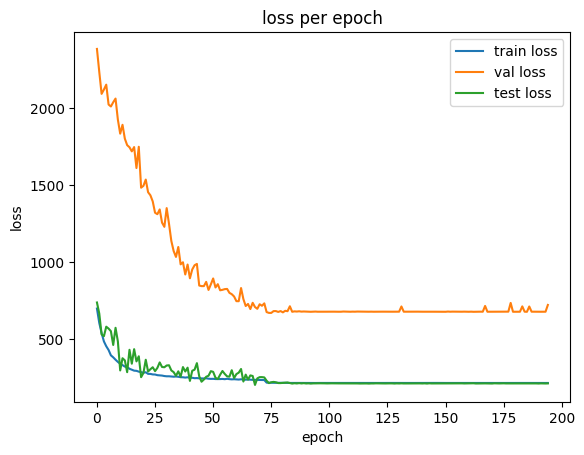

In [ ]:
plt.plot(train_losses[5:], label='train loss')
plt.plot(val_losses[5:], label='val loss')
plt.plot(test_losses[5:], label='test loss')
plt.legend()
plt.title("loss per epoch")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

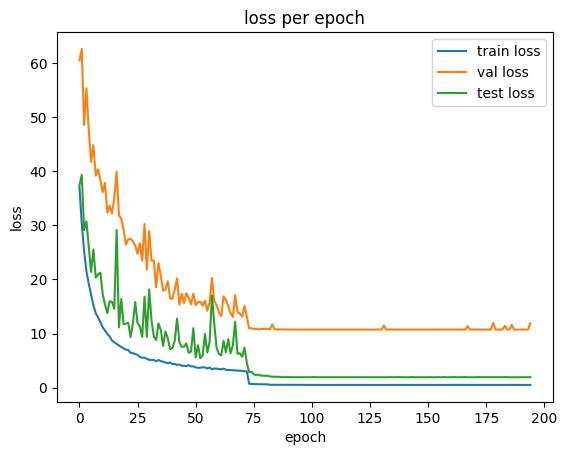

In [ ]:
plt.plot(len_train_losses[5:], label='train loss')
plt.plot(len_val_losses[5:], label='val loss')
plt.plot(len_test_losses[5:], label='test loss')
plt.legend()
plt.title("loss per epoch")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
len_train_losses[5:it].min()*49/4

5.945886852210149

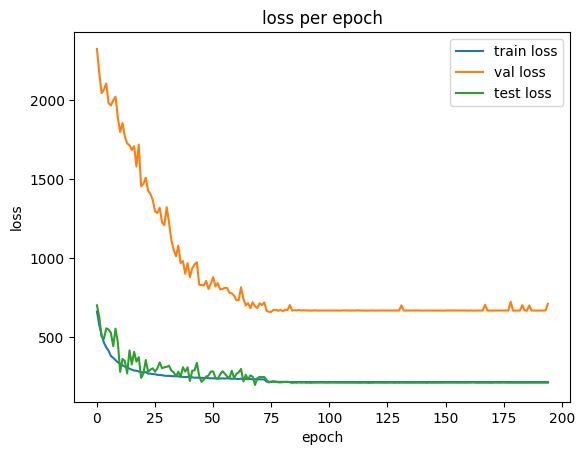

In [ ]:
plt.plot(train_losses[5:] - len_train_losses[5:], label='train loss')
plt.plot(val_losses[5:] - len_val_losses[5:], label='val loss')
plt.plot(test_losses[5:] - len_test_losses[5: ], label='test loss')
plt.legend()
plt.title("loss per epoch")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
best_test_loss

203.463734611136

In [ ]:
i = 0
L_tar = torch.zeros(101*len(Test_List), segment_len)
L_pred = torch.zeros(101*len(Test_List), segment_len)
for j in range(len(Test_List)):
    L_v_tar, L_v_pred = L_Pred(Test_List, j, model, tot_denormalize_transform, input_frames, predicted_frames, segment_len, device)
    L_tar[0+i:101+i, :] = L_v_tar
    L_pred[0+i:101+i, :] = L_v_pred
    i = i + 101

In [ ]:
RMSE_loss = RMSE_compute(L_tar, L_pred)
nRMSE_loss = nRMSE_compute(L_tar, L_pred)
r2_m = r2_compute(L_tar, L_pred)
print(f'RMSE: {RMSE_loss}, nRMSE: {nRMSE_loss}, r2: {r2_m}')

RMSE: 45.43718719482422, nRMSE: 0.03932800155229083, r2: 0.9939481627978345


In [ ]:
L_v_tar, L_v_pred = L_Pred(Test_List, 0, model, tot_denormalize_transform, input_frames, predicted_frames, segment_len, device)

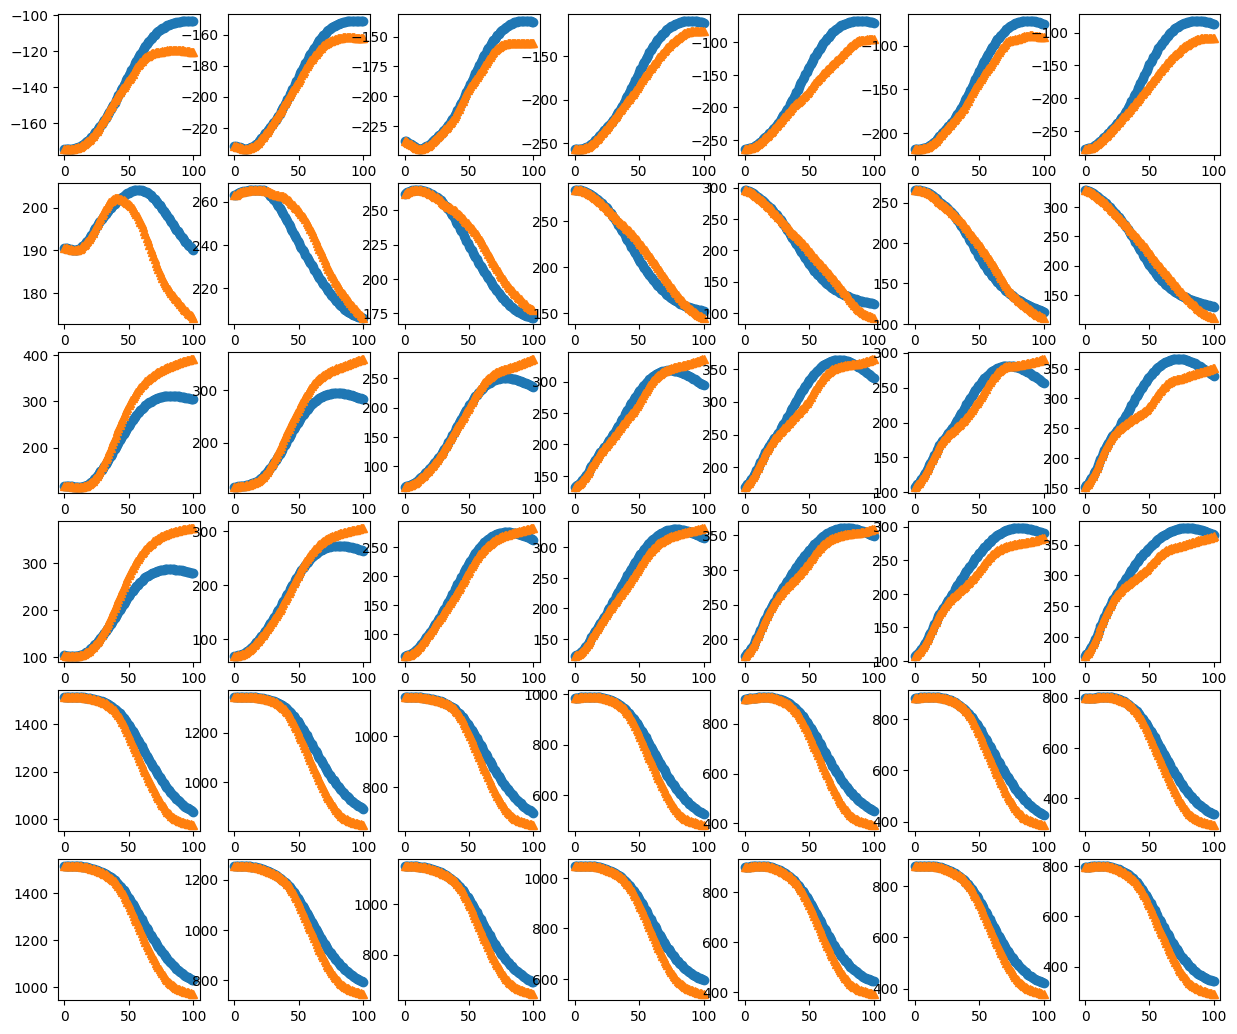

In [ ]:
plt.figure(figsize=(15, 15))
for i in range(L_v_tar.shape[2]):
  plt.subplot(7, 7, i+1)
  plt.plot(L_v_pred.squeeze().detach().cpu()[:, i], '-o', label='forecast prediction')
  plt.plot(L_v_tar.squeeze().detach().cpu()[:, i],'-^', label='forecast target' )
plt.savefig("output.png")

In [ ]:
np.where(test_losses == best_test_loss)

(array([73]),)

# Best MSE


In [15]:
# Load best val model
model = TransformerBased(49, d_model=96, num_head=16, num_feed_forward=512, drop_trans=0.25, enc_num_layers=1, dec_num_layers=3, drop_fc=0, out_neurons=64)


model.to(device)
model.load_state_dict(torch.load(os.path.join(path_to_folder, "last_model_params.pt")))
model.eval()

TransformerBased(
  (dim_expander): Linear(in_features=49, out_features=96, bias=True)
  (p_enc): Summer(
    (penc): PositionalEncoding1D()
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=96, out_features=96, bias=True)
        )
        (linear1): Linear(in_features=96, out_features=512, bias=True)
        (dropout): Dropout(p=0.25, inplace=False)
        (linear2): Linear(in_features=512, out_features=96, bias=True)
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.25, inplace=False)
        (dropout2): Dropout(p=0.25, inplace=False)
      )
    )
  )
  (decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_pr

In [ ]:
i = 0
L_tar = torch.zeros(101*len(Test_List), segment_len)
L_pred = torch.zeros(101*len(Test_List), segment_len)
for j in range(len(Test_List)):
    L_v_tar, L_v_pred = L_Pred(Test_List, j, model, tot_denormalize_transform, input_frames, predicted_frames, segment_len, device)
    L_tar[0+i:101+i, :] = L_v_tar
    L_pred[0+i:101+i, :] = L_v_pred
    i = i + 101

In [ ]:
def seg_cons(L_pred, seg_indexes, label):
    L_t = pd.DataFrame(L_pred.numpy())
    arm = L_t.iloc[:, seg_indexes].copy()
    dx = arm[seg_indexes[0]]-arm[seg_indexes[1]]
    dy = arm[seg_indexes[2]]-arm[seg_indexes[3]]
    dz = arm[seg_indexes[4]]-arm[seg_indexes[5]]

    arm['dx'] = dx
    arm['dy'] = dy
    arm['dz'] = dz
    arm = arm.drop(columns = seg_indexes)
    arm_len = np.sqrt((arm**2).sum(axis=1).iloc[:101])
    plt.plot(arm_len)
    plt.title(label)
    print(arm_len.mean(), arm_len.std())


278.0465 1.8169936


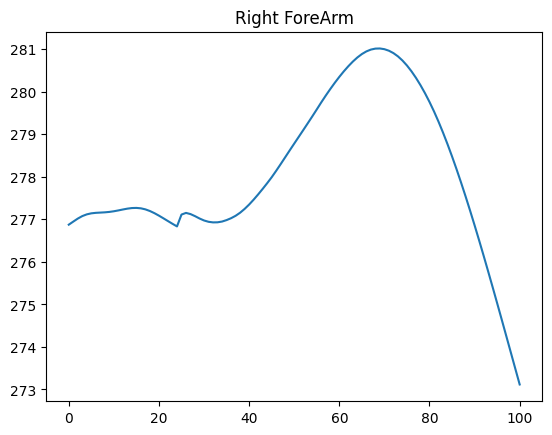

In [ ]:
# Right ForeArm
seg_cons(L_pred, [9, 11, 23, 25, 37, 39], 'Right ForeArm')

365.80618 9.211352


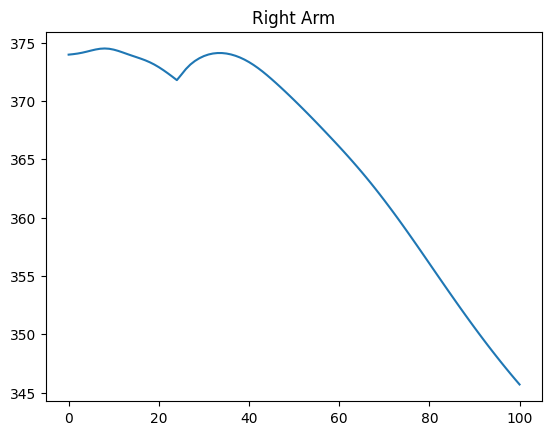

In [ ]:
# Right Arm
seg_cons(L_pred, [7, 9, 21, 23, 35, 37], 'Right Arm')

283.6272 5.4809713


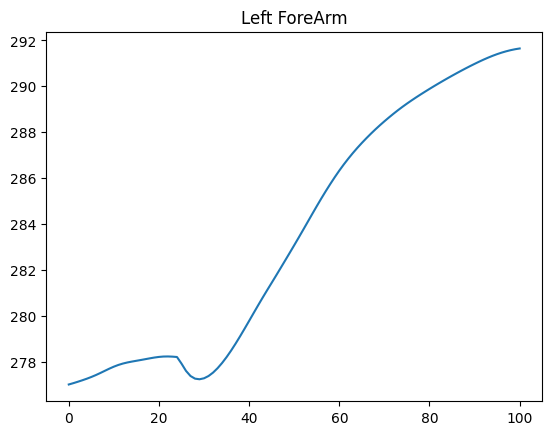

In [ ]:
# Left ForeArm
seg_cons(L_pred, [2, 4, 16, 18, 30, 32], 'Left ForeArm')

356.587 11.4451275


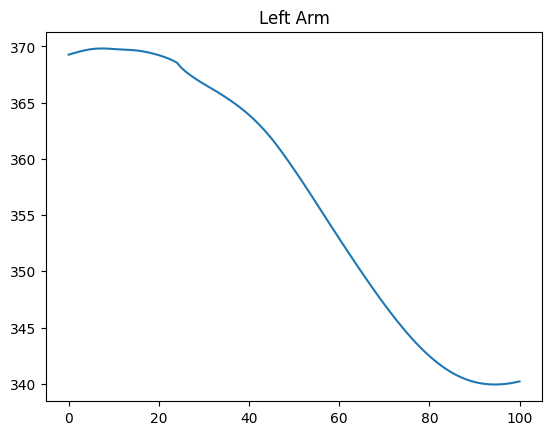

In [ ]:
# Left Arm
seg_cons(L_pred, [0, 2, 14, 16, 28, 30], 'Left Arm')

In [ ]:
my_path_list[36]

'/content/drive/MyDrive/DATA/Normalized/s13_fn/s13_109_fn.csv'

In [ ]:
RMSE_loss = RMSE_compute(L_tar, L_pred)
nRMSE_loss = nRMSE_compute(L_tar, L_pred)
r2_m = r2_compute(L_tar, L_pred)
print(f'RMSE: {RMSE_loss}, nRMSE: {nRMSE_loss}, r2: {r2_m}')

RMSE: 46.04319381713867, nRMSE: 0.040140223916596315, r2: 0.9937856566654971


In [16]:
L_v_tar, L_v_pred = L_Pred(Test_List, 200, model, tot_denormalize_transform, input_frames, predicted_frames, segment_len, device)

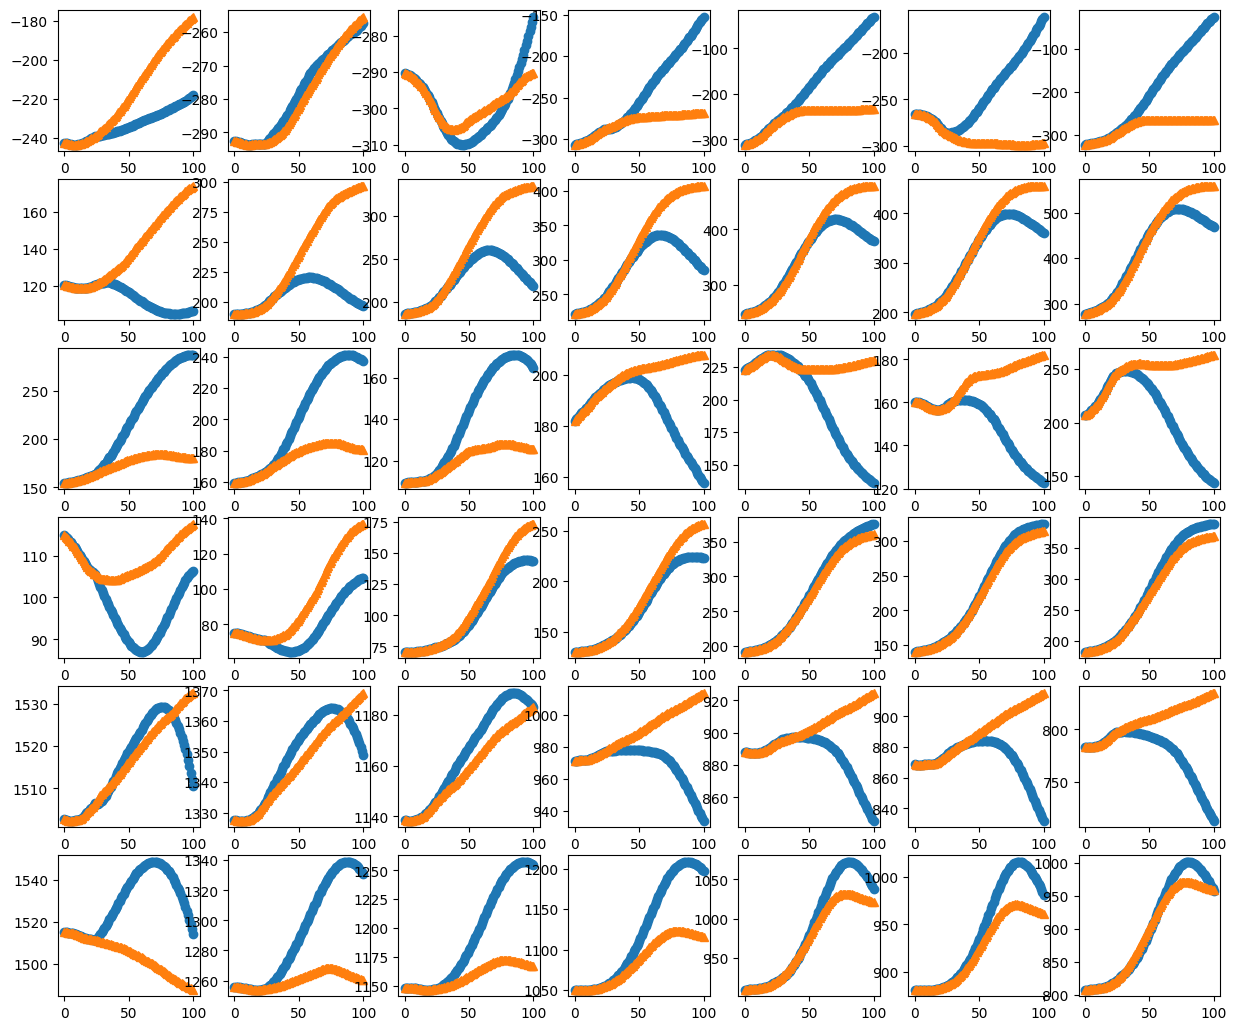

In [17]:
plt.figure(figsize=(15, 15))
for i in range(L_v_tar.shape[2]):
  plt.subplot(7, 7, i+1)
  plt.plot(L_v_pred.squeeze().detach().cpu()[:, i], '-o', label='forecast prediction')
  plt.plot(L_v_tar.squeeze().detach().cpu()[:, i],'-^', label='forecast target' )
plt.savefig("output.png")

# Export Results

In [18]:
tartar = pd.DataFrame(L_v_tar.cpu().squeeze())
tartar

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,-242.593094,-292.535889,-290.392700,-306.917236,-312.132782,-266.185303,-323.533203,120.354546,189.964127,185.970795,...,887.770020,868.624023,783.029053,1515.269531,1255.620850,1148.511475,1049.984253,909.646240,881.788696,808.001953
1,-242.744995,-292.635284,-290.473419,-306.556091,-311.291016,-266.131042,-322.930115,120.177551,189.896851,186.210464,...,887.732361,868.587280,782.986267,1515.190063,1255.566895,1148.477783,1050.033569,909.801636,881.733337,808.126953
2,-242.897446,-292.740417,-290.569977,-306.181702,-310.413300,-266.105560,-322.329865,119.991684,189.841278,186.450699,...,887.691589,868.555359,782.961426,1515.111816,1255.512695,1148.443359,1050.082275,909.959351,881.678162,808.264465
3,-243.047836,-292.855530,-290.697998,-305.776489,-309.455322,-266.142334,-321.724060,119.793289,189.809143,186.688950,...,887.648010,868.535706,782.973816,1515.034668,1255.456909,1148.405762,1050.131226,910.123413,881.625122,808.428345
4,-243.191437,-292.982025,-290.867371,-305.325684,-308.383942,-266.266663,-321.101868,119.585922,189.807587,186.917542,...,887.603699,868.533752,783.034729,1514.956665,1255.396606,1148.360107,1050.178833,910.294739,881.577148,808.625793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,-180.317520,-256.799591,-290.745178,-268.686249,-234.054840,-297.951355,-265.988953,171.972717,295.396729,333.332245,...,922.752686,913.323120,832.484680,1489.097290,1261.494507,1168.314331,1117.747559,1023.317505,963.563232,960.869812
97,-179.705322,-256.436646,-290.562042,-268.584076,-233.969528,-297.828674,-265.899902,172.490784,295.780060,333.614380,...,923.233032,913.805847,833.033325,1488.769409,1261.146606,1167.947754,1117.290771,1022.730042,963.025330,960.163086
98,-179.095993,-256.078003,-290.404236,-268.482758,-233.881470,-297.713104,-265.796783,172.998611,296.132019,333.925171,...,923.705017,914.309875,833.577209,1488.430786,1260.810791,1167.574463,1116.814453,1022.138367,962.475342,959.473755
99,-178.492859,-255.725281,-290.268188,-268.382904,-233.792099,-297.601196,-265.682709,173.497665,296.455170,334.258911,...,924.166504,914.829468,834.114624,1488.083130,1260.487061,1167.197266,1116.322754,1021.546753,961.917725,958.802856


In [19]:
tartar.to_csv('arm_tar.csv')

In [20]:
per = pd.DataFrame(L_v_pred.cpu().squeeze())
per

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,-242.593094,-292.535889,-290.392700,-306.917236,-312.132782,-266.185303,-323.533203,120.354546,189.964127,185.970795,...,887.770020,868.624023,783.029053,1515.269531,1255.620850,1148.511475,1049.984253,909.646240,881.788696,808.001953
1,-242.744995,-292.635284,-290.473419,-306.556091,-311.291016,-266.131042,-322.930115,120.177551,189.896851,186.210464,...,887.732361,868.587280,782.986267,1515.190063,1255.566895,1148.477783,1050.033569,909.801636,881.733337,808.126953
2,-242.897446,-292.740417,-290.569977,-306.181702,-310.413300,-266.105560,-322.329865,119.991684,189.841278,186.450699,...,887.691589,868.555359,782.961426,1515.111816,1255.512695,1148.443359,1050.082275,909.959351,881.678162,808.264465
3,-243.047836,-292.855530,-290.697998,-305.776489,-309.455322,-266.142334,-321.724060,119.793289,189.809143,186.688950,...,887.648010,868.535706,782.973816,1515.034668,1255.456909,1148.405762,1050.131226,910.123413,881.625122,808.428345
4,-243.191437,-292.982025,-290.867371,-305.325684,-308.383942,-266.266663,-321.101868,119.585922,189.807587,186.917542,...,887.603699,868.533752,783.034729,1514.956665,1255.396606,1148.360107,1050.178833,910.294739,881.577148,808.625793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,-220.289139,-258.909454,-280.086548,-161.467255,-41.873627,-170.878510,-36.939629,105.627586,198.401917,223.937317,...,851.193176,839.020264,721.768250,1523.361938,1335.254883,1256.791016,1203.538208,1049.944092,992.517151,971.614990
97,-219.759399,-258.509186,-278.781006,-159.168259,-38.943413,-168.399612,-33.746857,105.827843,197.852676,222.329147,...,849.687988,837.199097,719.532837,1521.235596,1334.252930,1256.368408,1202.149414,1047.199463,989.846741,968.290344
98,-219.206177,-258.099884,-277.452454,-156.887177,-36.060387,-165.913742,-30.623497,106.054367,197.338074,220.744781,...,848.223206,835.401184,717.346313,1519.020020,1333.138916,1255.820557,1200.621094,1044.338745,987.066467,964.847656
99,-218.644012,-257.691711,-276.101685,-154.627686,-33.215324,-163.429688,-27.563606,106.307053,196.854202,219.188339,...,846.797058,833.621582,715.209961,1516.729004,1331.920776,1255.146484,1198.966064,1041.374512,984.177002,961.297241


In [21]:
per.to_csv('arm_per.csv')

In [23]:
my_path_list[200]

'/content/drive/MyDrive/DATA/Normalized/s13_fn/s13_82_fn.csv'